In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

## Data Collection

In [3]:

# Load the dataset
data = pd.read_csv("amazon_reviews_with_sentiments_50k.csv")

# Display the first few rows of the dataset
print(data.head())

# Check for null values
print(data.isnull().sum())

# Drop unnecessary columns
data = data[['Text', 'Sentiment']]  # Keeping only the relevant columns


   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  \
0  Good Quality Dog Food  I have bought several of the Vitality canned d...   


## Data Preprocessing

In [5]:
import re
import string

# Function to clean text: convert to lowercase, remove punctuation, numbers, and special characters
def text_clean_1(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)  # Remove content inside square brackets
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text)  # Remove numbers
    return text

# Apply the cleaning function
data['Cleaned_Text'] = data['Text'].apply(lambda x: text_clean_1(x))
print(data[['Text', 'Cleaned_Text']].head())


                                                Text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   
2  This is a confection that has been around a fe...   
3  If you are looking for the secret ingredient i...   
4  Great taffy at a great price.  There was a wid...   

                                        Cleaned_Text  
0  i have bought several of the vitality canned d...  
1  product arrived labeled as jumbo salted peanut...  
2  this is a confection that has been around a fe...  
3  if you are looking for the secret ingredient i...  
4  great taffy at a great price  there was a wide...  


## Exploratory Data Analysis (EDA)

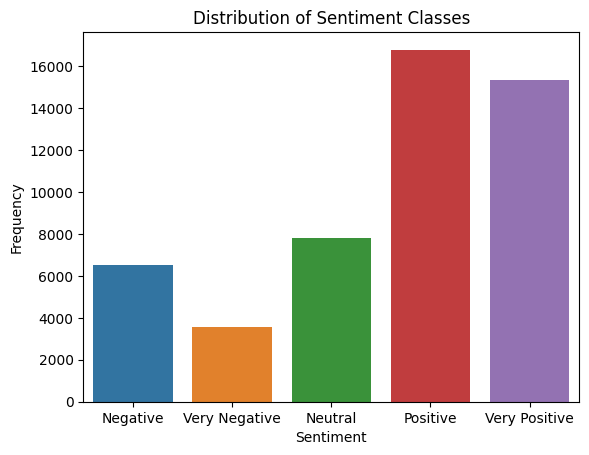

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of sentiment classes
sns.countplot(x=data['Sentiment'])
plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()


Sentiment
Positive    32125
Negative    10068
Neutral      7807
Name: count, dtype: int64


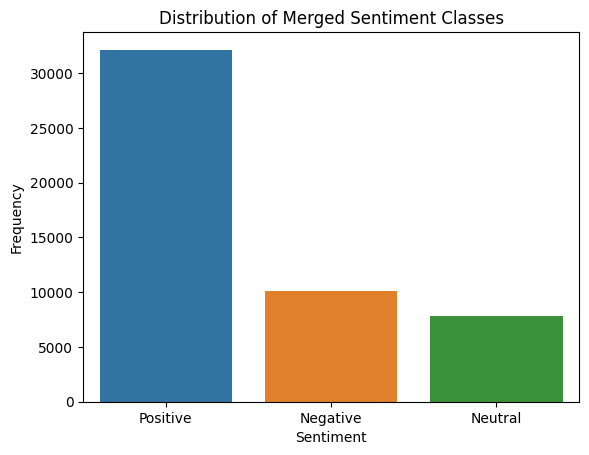

In [7]:
# Merge the sentiment classes
data['Sentiment'] = data['Sentiment'].replace({
    'Very Negative': 'Negative', 
    'Negative': 'Negative',
    'Positive': 'Positive',
    'Very Positive': 'Positive'
})

# Check the new distribution
print(data['Sentiment'].value_counts())

# Plot the updated sentiment distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=data['Sentiment'], order=data['Sentiment'].value_counts().index)
plt.title("Distribution of Merged Sentiment Classes")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()


Sentiment
Negative    8000
Positive    8000
Neutral     7807
Name: count, dtype: int64


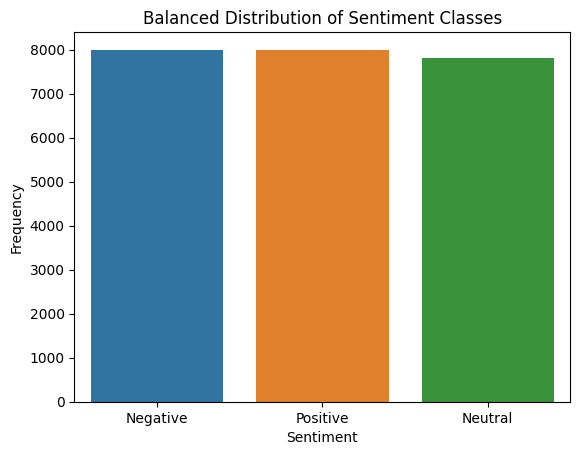

In [52]:
import pandas as pd

# Separate the data into different classes
negative = data[data['Sentiment'] == 'Negative']
neutral = data[data['Sentiment'] == 'Neutral']
positive = data[data['Sentiment'] == 'Positive']

# Sample each class to have a maximum of 8000 rows (or the size of the class if smaller)
negative_sampled = negative.sample(n=min(8000, len(negative)), random_state=112)
neutral_sampled = neutral.sample(n=min(8000, len(neutral)), random_state=112)
positive_sampled = positive.sample(n=min(8000, len(positive)), random_state=112)

# Combine the balanced data
balanced_data = pd.concat([negative_sampled, neutral_sampled, positive_sampled])

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1, random_state=112).reset_index(drop=True)

# Check the distribution of the balanced data
print(balanced_data['Sentiment'].value_counts())

# Plot the distribution of the balanced sentiment classes
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=balanced_data['Sentiment'], order=balanced_data['Sentiment'].value_counts().index)
plt.title("Balanced Distribution of Sentiment Classes")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()


## Vectorization

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizing the cleaned text using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(balanced_data['Cleaned_Text']).toarray()

# Target variable
y = balanced_data['Sentiment']

## Train-Test Split

In [67]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (16664, 5000)
Testing Data Shape: (7143, 5000)


## Model Building

#### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Naive Bayes

In [57]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)


#### Random Forest Classifier

In [58]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=80, random_state=112)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


#### XGBoost Classifier

In [59]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Convert the target labels (y_train, y_test) to numeric values
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize the XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model with the encoded labels
xgb.fit(X_train, y_train_encoded)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

# Decode the predictions back to the original labels
y_pred_decoded = label_encoder.inverse_transform(y_pred_xgb)

# Optionally, print the decoded predictions


### Model Evaluation

In [69]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(y_test, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Evaluate Logistic Regression
evaluate_model(y_test, y_pred_lr, "Logistic Regression")

# Evaluate Naive Bayes
evaluate_model(y_test, y_pred_nb, "Naive Bayes")

# Evaluate SVM

# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
evaluate_model(y_test_encoded, y_pred_xgb, "XGBoost")



Logistic Regression Metrics:
Accuracy: 0.6677866442671146
Confusion Matrix:
 [[1642  459  301]
 [ 527 1362  439]
 [ 260  387 1766]]
Classification Report:
               precision    recall  f1-score   support

    Negative       0.68      0.68      0.68      2402
     Neutral       0.62      0.59      0.60      2328
    Positive       0.70      0.73      0.72      2413

    accuracy                           0.67      7143
   macro avg       0.67      0.67      0.67      7143
weighted avg       0.67      0.67      0.67      7143


Naive Bayes Metrics:
Accuracy: 0.33221335573288535
Confusion Matrix:
 [[828 712 862]
 [816 670 842]
 [882 656 875]]
Classification Report:
               precision    recall  f1-score   support

    Negative       0.33      0.34      0.34      2402
     Neutral       0.33      0.29      0.31      2328
    Positive       0.34      0.36      0.35      2413

    accuracy                           0.33      7143
   macro avg       0.33      0.33      0.33      

## Prepare Data for Neural Networks

### Tokenization and Padding

In [61]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Initialize the tokenizer and fit on the cleaned text
max_words = 10000  # Maximum number of words in the vocabulary
max_len = 500     # Maximum length of each review

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_data['Cleaned_Text'])

# Convert text to sequences and pad them
X_seq = tokenizer.texts_to_sequences(balanced_data['Cleaned_Text'])
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

# Convert the sentiment labels to numeric values using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(balanced_data['Sentiment'])

# One-hot encode the target variable
y_categorical = to_categorical(y_encoded, num_classes=3)

# Now X_padded and y_categorical can be used for training your model


### Split Data into Training and Testing Sets

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (19045, 500)
Testing Data Shape: (4762, 500)


### Build a Neural Network Model

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)),  # Embedding layer
    LSTM(128, return_sequences=True),                                      # LSTM layer
    Dropout(0.3),                                                          # Dropout for regularization
    LSTM(64),                                                              # Another LSTM layer
    Dense(32, activation='relu'),   # Fully connected layer
    Dropout(0.3),                                                          # Dropout
    Dense(3, activation='softmax')                                         # Output layer (3 classes)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 500, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,463,171 (5.58 MB)

 Trainable params: 1,463,171 (5.58 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Neural Network

In [64]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # Number of epochs
    batch_size=32,  # Batch size
    verbose=1
)

Epoch 1/10
596/596 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.3360 - loss: 1.0999 - val_accuracy: 0.3312 - val_loss: 1.0986
Epoch 2/10
596/596 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.3398 - loss: 1.0986 - val_accuracy: 0.3312 - val_loss: 1.0986
Epoch 3/10
596/596 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.3339 - loss: 1.0986 - val_accuracy: 0.3425 - val_loss: 1.0985
Epoch 4/10
596/596 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.3297 - loss: 1.0987 - val_accuracy: 0.3255 - val_loss: 1.0993
Epoch 5/10
596/596 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.3363 - loss: 1.1005 - val_accuracy: 0.3307 - val_loss: 1.0997
Epoch 6/10
596/596 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.3241 - loss: 1.0993 - val_accuracy: 0.3310 - val_loss: 1.0986
Epoch 7/10
596/596 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.3272 - loss: 1.0978 - val_accuracy: 0.3307 - val_loss: 1.0989
Epoch 8/10
596/596 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - accuracy: 0.3395 - loss: 1.0958 - 

### Evaluate the Model

149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3400 - loss: 1.0963
Test Accuracy: 0.34


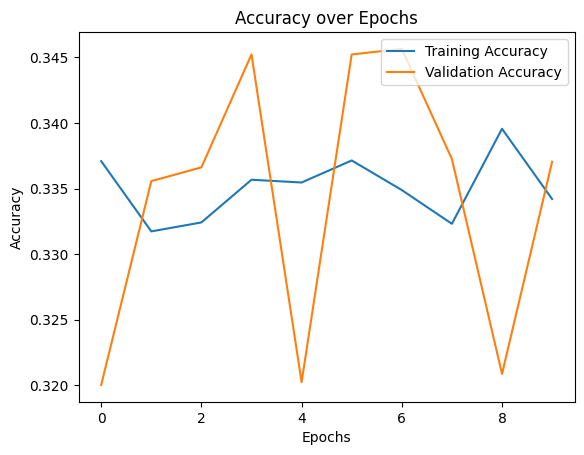

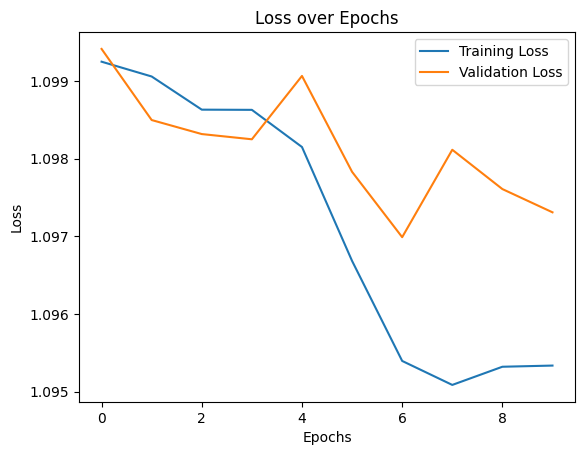

In [33]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Save the best Model

In [70]:
import joblib
from sklearn.linear_model import LogisticRegression

# Train the model
joblib.dump(lr, 'logistic_regression_model.pkl')  # Save the LogisticRegression model
joblib.dump(tokenizer, 'tokenizer.pkl') 


['tokenizer.pkl']